In [25]:
import cv2         
import numpy as np   
import matplotlib.pyplot as plt

In [26]:
def turnGrayscale(image_path):    
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray

In [27]:
def adaptiveThresholding(image, block_size=15, C=2, method='gaussian'):
   
    # Ensure the image is grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Select the adaptive method
    if method.lower() == 'gaussian':
        adaptive_method = cv2.ADAPTIVE_THRESH_GAUSSIAN_C
    else:
        adaptive_method = cv2.ADAPTIVE_THRESH_MEAN_C

    # Apply adaptive thresholding
    thresholded_image = cv2.adaptiveThreshold(
        image,
        255,  # Max intensity value
        adaptive_method,  # Adaptive method
        cv2.THRESH_BINARY,  # Binary thresholding
        block_size,  # Size of the local region
        C  # Constant to fine-tune thresholding
    )

    return thresholded_image


In [28]:
def medianFilter(image):
    img_blur = cv2.blur(image, (1, 17))
    img_filtered = cv2.medianBlur(img_blur, 5)

    img_filtered = np.uint8(np.clip(img_filtered, 0, 255))

    _, img_thresh = cv2.threshold(img_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return img_thresh

In [29]:
def histogramStretching(image):
    min = np.min(image)
    max = np.max(image)
    image = np.uint8((image - min) / (max - min) * 255)
    return image

In [30]:
def rotateBarcode(image):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

    edges = cv2.Canny(blurred_image, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)

        rect = cv2.minAreaRect(largest_contour)
        box = cv2.boxPoints(rect)
        box = np.int32(box)

        # Get the angle of rotation of the bounding box
        angle = rect[-1]
        
        # If the angle is too extreme, adjust it
        if angle < -45:
            angle += 90  # Correct the angle for proper orientation

        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        
        # Calculate the rotation matrix
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        
        # Get the new bounding box size (to prevent cropping)
        cos = np.abs(rotation_matrix[0, 0])
        sin = np.abs(rotation_matrix[0, 1])

        new_w = int(h * sin + w * cos)
        new_h = int(h * cos + w * sin)

        # Adjust the rotation matrix to take into account translation for full image retention
        rotation_matrix[0, 2] += (new_w / 2) - center[0]
        rotation_matrix[1, 2] += (new_h / 2) - center[1]

        # Rotate the image without cropping
        img_rotated = cv2.warpAffine(image, rotation_matrix, (new_w, new_h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

        # Check if further 90-degree rotation is necessary
        if new_w < new_h:  # Check if the rotated image is taller than wide
            img_rotated_90 = cv2.rotate(img_rotated, cv2.ROTATE_90_CLOCKWISE)
        else:
            img_rotated_90 = img_rotated

    else:
        # If no contours are found, return the original image
        img_rotated_90 = image

    return img_rotated_90


In [31]:
def closeOpen(image):

    kernel_height = image.shape[0] // 5  
    kernel_width = 3
    kernel = np.ones((kernel_height, kernel_width), np.uint8)

    img_closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=1)

    img_opened = cv2.morphologyEx(img_closed, cv2.MORPH_OPEN, kernel, iterations=1)

    return img_opened

In [32]:
def closeOpenFull(image):

    kernel_height = image.shape[0]   
    kernel_width = 3
    kernel = np.ones((kernel_height, kernel_width), np.uint8)

    img_closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=1)

    img_opened = cv2.morphologyEx(img_closed, cv2.MORPH_OPEN, kernel, iterations=1)

    return img_opened

In [33]:
def extractBarcode(image):
    img_thresh_inv = cv2.bitwise_not(image)

    x, y, w, h = cv2.boundingRect(img_thresh_inv)

    barcode = image[y:y+h-h//4, x:x+w]

    
    return barcode


In [34]:
def detectSineWaveNoise(image):
    if image is None or image.size == 0:
        raise ValueError("Input image is empty or invalid.")

    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f) 
    
    magnitude_spectrum = np.abs(fshift)
    
    avg_freq = np.mean(magnitude_spectrum)
    
    low_freq_threshold = avg_freq * 1.5 
    magnitude_spectrum[magnitude_spectrum < low_freq_threshold] = 0
    
    peak_threshold = np.max(magnitude_spectrum) * 0.1 
    
    peaks = np.where(magnitude_spectrum > peak_threshold)

    if len(peaks[0]) < 2:
        return False

    peak_distances = []
    for i in range(1, len(peaks[0])):
        distance = np.linalg.norm(np.array([peaks[0][i], peaks[1][i]]) - np.array([peaks[0][i-1], peaks[1][i-1]]))
        peak_distances.append(distance)

    mean_distance = np.mean(peak_distances)
    regularity = np.std(peak_distances) < mean_distance * 0.2
    
    if regularity:
        return True
    else:
        return False

In [35]:
def decode_code11_barcode(image, tolerance):

    NARROW = "0"
    WIDE = "1"
    code11_widths = {
        "00110": "Stop/Start",
        "10001": "1",
        "01001": "2",
        "11000": "3",
        "00101": "4",
        "10100": "5",
        "01100": "6",
        "00011": "7",
        "10010": "8",
        "10000": "9",
        "00001": "0",
        "00100": "-",
    }

    # Get the average of each column in the image
    mean = image.mean(axis=0)

    # Set it to black or white based on its value
    mean[mean <= 127] = 1
    mean[mean > 128] = 0

    # Convert to string of pixels
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    # Determine the narrow bar size
    narrow_bar_size = 0
    for pixel in pixels:
        if pixel == "1":
            narrow_bar_size += 1
        else:
            break

    wide_bar_size = narrow_bar_size * 2
    min_narrow = narrow_bar_size * (1 - tolerance)
    max_narrow = narrow_bar_size * (1 + tolerance)
    min_wide = wide_bar_size * (1 - tolerance)
    max_wide = wide_bar_size * (1 + tolerance)

    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False

    while pixel_index < len(pixels):
        if skip_next:
            pixel_index += int(narrow_bar_size)
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except IndexError:
            pass
        pixel_index += 1

        if min_narrow <= count <= max_narrow:
            current_digit_widths += NARROW
        elif min_wide <= count <= max_wide:
            current_digit_widths += WIDE
        else:
            # Ignore invalid bar widths
            current_digit_widths = ""

        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True  # Skip the separator in the next iteration

    return digits


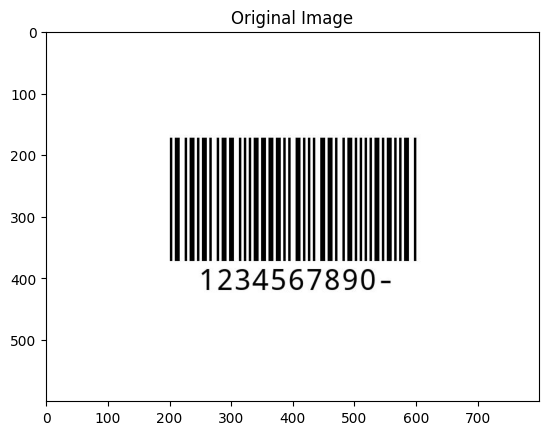

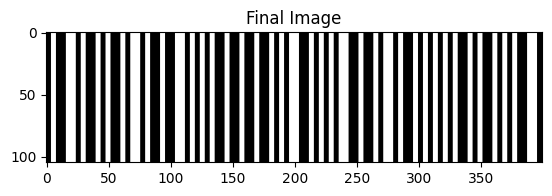

Decoded barcode for image 1: ['Stop/Start', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '-', 'Stop/Start']
Test 1: Pass


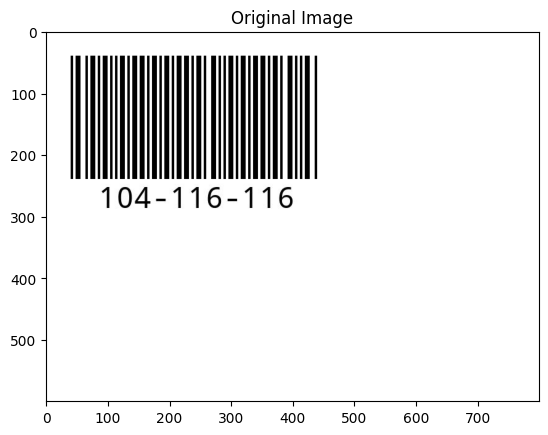

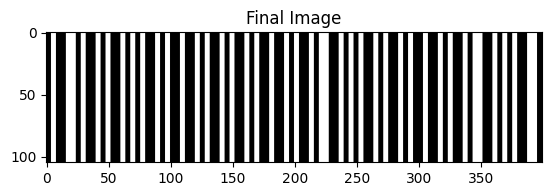

Decoded barcode for image 2: ['Stop/Start', '1', '0', '4', '-', '1', '1', '6', '-', '1', '1', '6', 'Stop/Start']
Test 2: Pass


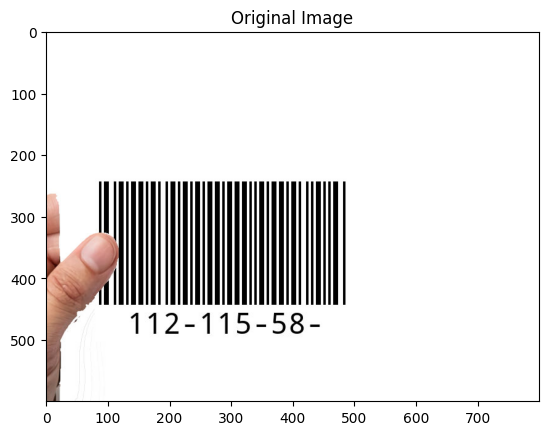

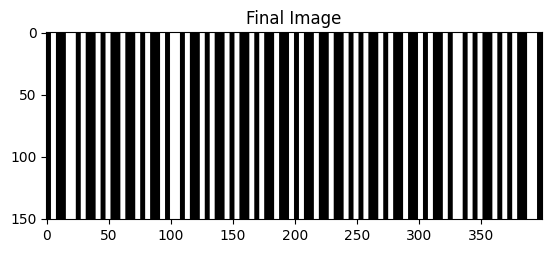

Decoded barcode for image 3: ['Stop/Start', '1', '1', '2', '-', '1', '1', '5', '-', '5', '8', '-', 'Stop/Start']
Test 3: Pass


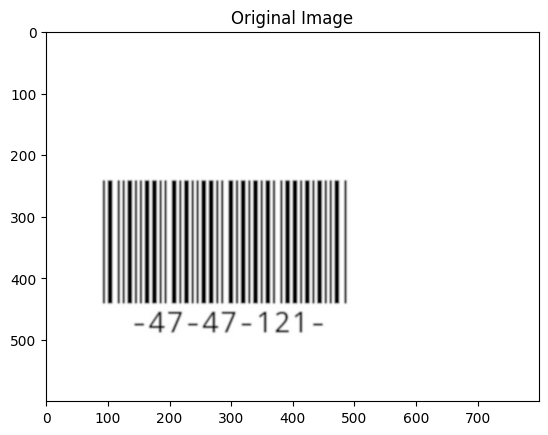

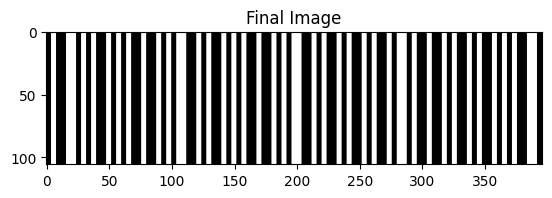

Decoded barcode for image 4: ['Stop/Start', '-', '4', '7', '-', '4', '7', '-', '1', '2', '1', '-', 'Stop/Start']
Test 4: Pass


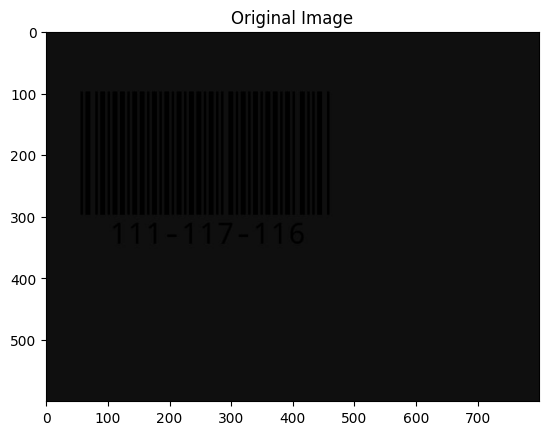

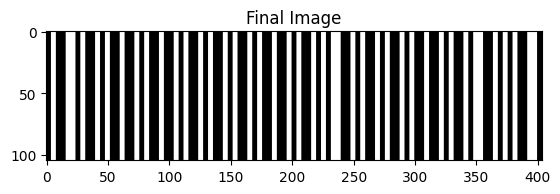

Decoded barcode for image 5: ['Stop/Start', '1', '1', '1', '-', '1', '1', '7', '-', '1', '1', '6', 'Stop/Start']
Test 5: Pass


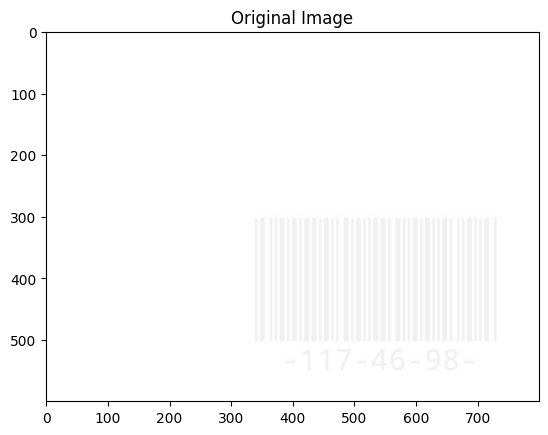

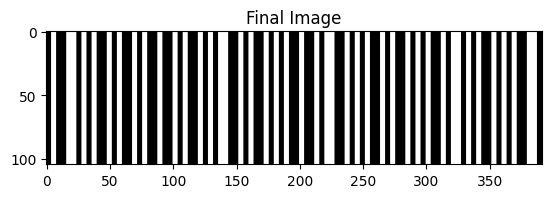

Decoded barcode for image 6: ['Stop/Start', '-', '1', '1', '7', '-', '4', '6', '-', '9', '8', '-', 'Stop/Start']
Test 6: Pass


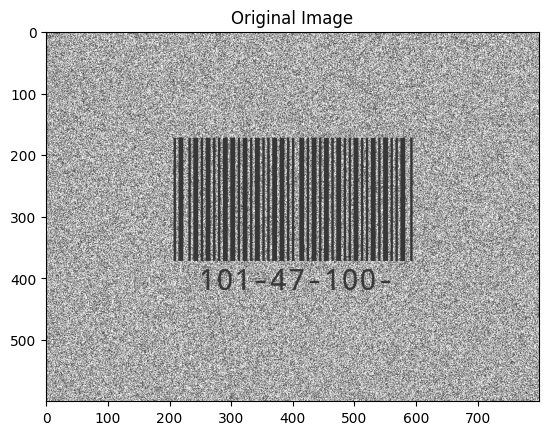

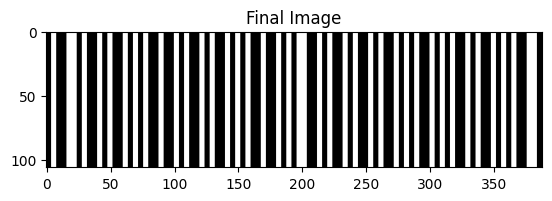

Decoded barcode for image 7: ['Stop/Start', '1', '0', '1', '-', '4', '7', '-', '1', '0', '0', '-', 'Stop/Start']
Test 7: Pass


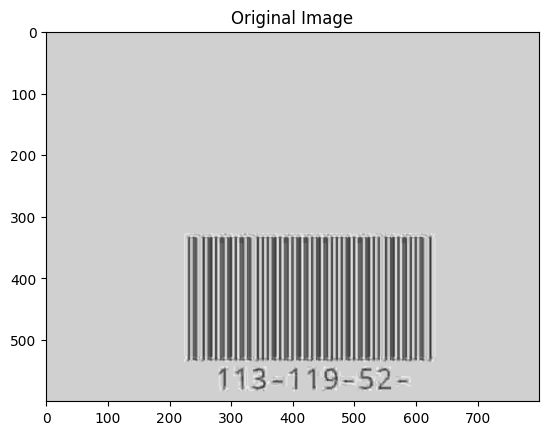

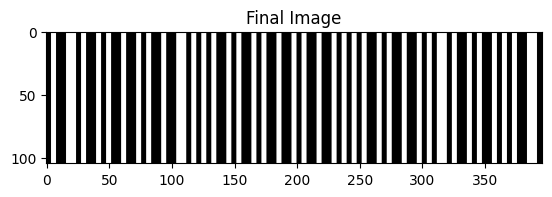

Decoded barcode for image 8: ['Stop/Start', '1', '1', '3', '-', '1', '1', '9', '-', '5', '2', '-', 'Stop/Start']
Test 8: Pass


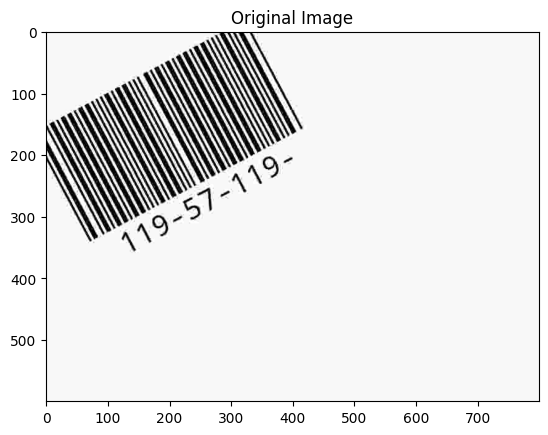

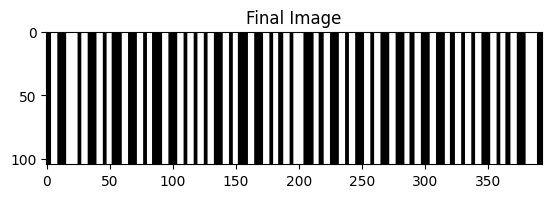

Decoded barcode for image 9: ['Stop/Start', '1', '1', '9', '-', '5', '7', '-', '1', '1', '9', '-', 'Stop/Start']
Test 9: Pass


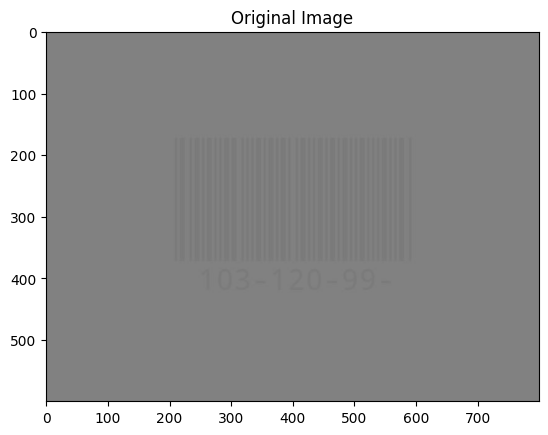

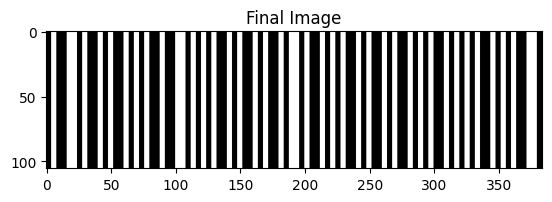

Decoded barcode for image 10: ['Stop/Start', '1', '0', '3', '-', '1', '2', '0', '-', '9', '9', '-', 'Stop/Start']
Test 10: Pass


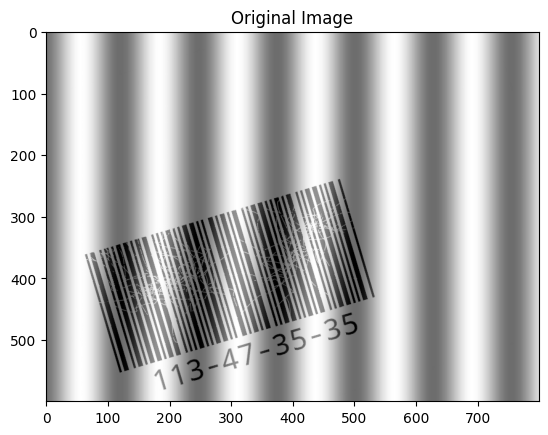

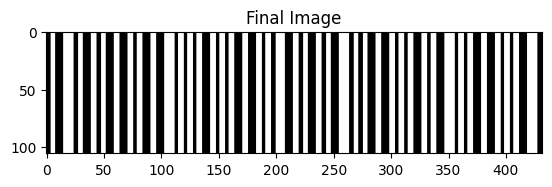

Decoded barcode for image 11: ['Stop/Start', '1', '1', '3', '-', '4', '7', '-', '3', '5', '-', '3', '5', 'Stop/Start']
Test 11: Pass


In [36]:
images = [  'Test Cases/01 - lol easy.jpg', 
            'Test Cases/02 - still easy.jpg', 
            'Test Cases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg', 
            'Test Cases/04 - fen el nadara.jpg', 
            'Test Cases/05 - meen taffa el nour!!!.jpg', 
            'Test Cases/06 - meen fata7 el nour 333eenaaayy.jpg',
            'Test Cases/07 - mal7 w felfel.jpg', 
            'Test Cases/08 - compresso espresso.jpg',                                    
            'Test Cases/09 - e3del el soora ya3ammm.jpg',                                
            'Test Cases/10 - wen el kontraastttt.jpg', 
            'Test Cases/11 - bayza 5ales di bsara7a.jpg',
            ]

barcodes = [
            ['Stop/Start', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '-', 'Stop/Start'],
            ['Stop/Start', '1', '0', '4', '-', '1', '1', '6', '-', '1', '1', '6', 'Stop/Start'],
            ['Stop/Start', '1', '1', '2', '-', '1', '1', '5', '-', '5', '8', '-', 'Stop/Start'],
            ['Stop/Start', '-', '4', '7', '-', '4', '7', '-', '1', '2', '1', '-', 'Stop/Start'],
            ['Stop/Start', '1', '1', '1', '-', '1', '1', '7', '-', '1', '1', '6', 'Stop/Start'],
            ['Stop/Start', '-', '1', '1', '7', '-', '4', '6', '-', '9', '8', '-', 'Stop/Start'],
            ['Stop/Start', '1', '0', '1', '-', '4', '7', '-', '1', '0', '0', '-', 'Stop/Start'],
            ['Stop/Start', '1', '1', '3', '-', '1', '1', '9', '-', '5', '2', '-', 'Stop/Start'],
            ['Stop/Start', '1', '1', '9', '-', '5', '7', '-', '1', '1', '9', '-', 'Stop/Start'],
            ['Stop/Start', '1', '0', '3', '-', '1', '2', '0', '-', '9', '9', '-', 'Stop/Start'],
            ['Stop/Start', '1', '1', '3', '-', '4', '7', '-', '3', '5', '-', '3', '5', 'Stop/Start']
]                              

for i, image_path in enumerate(images):

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title('Original Image')
    plt.show()

    image = turnGrayscale(image_path)

    sine_wave_noise_detected = detectSineWaveNoise(image)
     
    if sine_wave_noise_detected:
        image = adaptiveThresholding(image)

    image = rotateBarcode(image)
    image = medianFilter(image)

    image = histogramStretching(image)

    image = extractBarcode(image)

    image = closeOpen(image)

    image = extractBarcode(image)

    image = closeOpenFull(image)

    image = extractBarcode(image)

    plt.imshow(image , cmap='gray')
    plt.title('Final Image')
    plt.show()

    decoded = decode_code11_barcode(image , 0.3)

    

    print(f"Decoded barcode for image {i + 1}: {decoded}")
    print(f"Test {i+1}: {'Pass' if decoded == barcodes[i] else 'Fail'}")
